# Inicialização

## Carregando bibliotecas e funções de auxílio

In [7]:
from sklearn.base import BaseEstimator
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import xml.etree.ElementTree as et


def parse_xml_to_df(xml_root):
    # Cria um dataframe vazio em que as linhas serão concatenadas.
    df = pd.DataFrame(columns=['similarity', 't', 'h'])
    # Para cada par na root.
    for pair in xml_root:
        # Recupera o valor de t.
        t = pair[0].text
        # Recupera o valor de h.
        h = pair[1].text
        # Recupera o valor da variável target.
        is_entailment = pair.attrib['entailment'] == 'Entailment'
        # Recupera o valor de similaridade atribuído.
        similarity = float(pair.attrib['similarity'])
        # Constroi a nova linha.
        new_line = pd.DataFrame([{'t': t, 'h': h, 'similarity': similarity, 'is_entailment': is_entailment}])
        # Adiciona ao dataframe.
        df = pd.concat([df, new_line], ignore_index=True)
    return df

    
class GenericEstimator(BaseEstimator):
    # Classificador genérico para usar o gridsearch com múltiplos algoritmos.
    def fit(self): pass
    
    def score(self): pass


def get_classification_results(y_train, y_train_pred, y_dev, y_dev_pred, y_test, y_test_pred):
    # Cria um dataframe com todos o resultado de todas as métricas.
    return pd.DataFrame({
        'type':['train', 'dev', 'test'],
        
        'f1': [f1_score(y_train, y_train_pred), 
               f1_score(y_dev, y_dev_pred), 
               f1_score(y_test, y_test_pred)],

        'precision': [precision_score(y_train, y_train_pred), 
                      precision_score(y_dev, y_dev_pred), 
                      precision_score(y_test, y_test_pred)],

        'recall': [recall_score(y_train, y_train_pred), 
                      recall_score(y_dev, y_dev_pred), 
                      recall_score(y_test, y_test_pred)],

        'accuracy': [accuracy_score(y_train, y_train_pred), 
                     accuracy_score(y_dev, y_dev_pred), 
                     accuracy_score(y_test, y_test_pred)],
    })

## Carregando conjuntos de dados

In [29]:
# Recupera o arquivo de entrada de treinamento.
train_xml_root = et.parse('../data/assin2-train.xml').getroot()
# Cria o dataframe de treinamento.
df_train = parse_xml_to_df(train_xml_root)

# Recupera o arquivo de entrada de validação.
dev_xml_root = et.parse('../data/assin2-dev.xml').getroot()
# Cria o dataframe de validação.
df_dev = parse_xml_to_df(dev_xml_root)

# Recupera o arquivo de entrada de validação.
test_xml_root = et.parse('../data/assin2-test.xml').getroot()
df_test = parse_xml_to_df(test_xml_root)



In [9]:
print('Shape de treinamento:', df_train.shape)
print('Shape de validação:', df_dev.shape)
print('Shape de teste:', df_test.shape)

Shape de treinamento: (6500, 4)
Shape de validação: (500, 4)
Shape de teste: (2448, 4)


## Carregando stopwords

In [10]:
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')

language = "portuguese"

portuguese_stopwords = stopwords.words(language)

[nltk_data] Downloading package stopwords to /home/gi/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Limpeza dos dados

In [12]:
import unidecode 

def clean_string(x):
    return unidecode.unidecode(x.lower())

# Removendo acentos para normalizar as palavras no conjunto de treinameto.
df_train['t'] = df_train['t'].apply(clean_string)
df_train['h'] = df_train['h'].apply(clean_string)

# Removendo acentos para normalizar as palavras no conjunto de validação.
df_dev['t'] = df_dev['t'].apply(clean_string)
df_dev['h'] = df_dev['h'].apply(clean_string)

# Removendo acentos para normalizar as palavras no conjunto de teste.
df_test['t'] = df_test['t'].apply(clean_string)
df_test['h'] = df_test['h'].apply(clean_string)

# Modelagem

## Abordagem Simbólica: Comparação de tamanho, quantidade de tokens iguais e presença de negação

### Treinamento do modelo

In [42]:
# A abordagem simbólica utilizada leva em consideração critérios teóricos para a diferenciação entre pares de sentenças com e sem inferências
# Um conjunto de regras é formado para definir se a sentença A acarreta a sentença B
# Considerando que sentenças específicas como "Um cachorro anda rapidamente pela areia da praia" podem acarretar sentenças mais gerais como "Um cachorro anda pela praia", mas não o contrário, considera-se que a sentença A deve ser maior ou igual à B
# Regra 1 de acarretamento: A sentença B deve ser menor ou igual à sentença A em tamanho para que B seja acarretada por A
# Regra 2 de acarretamento: As sentenças devem ser significativamente parecidas - verifica-se se o número de palavras em comum dividido pelo tamanho da sentença B é maior que 50%
# Se ambas as regras forem verdade, a sentença B é classificada como acarretada pela A
# Por fim, se a sentença A contiver o termo "não" e a sentença B não, considera-se que não há relação de inferência entre as sentenças
def symbolic_approach(df_data):
    predictions = []
    for index in df_data.index:      
        sentence_A = df_data['t'][index].split()
        sentence_B = df_data['h'][index].split()
        common_words = [word for word in sentence_A if word in sentence_B]
        
        if len(sentence_B) <= len(sentence_A) and len(common_words)/len(sentence_B) > 0.5:
            prediction = True
        else:
            prediction = False
        #if "não" in sentence_A and "não" not in sentence_B: # não ou nao?
        #    prediction = False
        #if "nenhum" in sentence_pair[0] and "não" not in sentence_pair[1]:
        #if "ninguém" in sentence_pair[0] and "não" not in sentence_pair[1]:
        #if "nem" in sentence_pair[0] and "não" not in sentence_pair[1]:

        predictions.append(prediction) 
    return predictions

y_train_pred = symbolic_approach(df_train)
y_dev_pred = symbolic_approach(df_dev)
y_test_pred = symbolic_approach(df_test)

# Transforma os dados da anotação no formato de vetor binário (0 para não acarretamento, 1 para acarretamento)
y_train = df_train['is_entailment'].astype(int)
y_dev = df_dev['is_entailment'].astype(int)
y_test = df_test['is_entailment'].astype(int)

# Calcula as métricas de performance dos resultados do modelo.
df_symbolic_approach_results = get_classification_results(
    y_train, 
    y_train_pred, 
    y_dev, 
    y_dev_pred, 
    y_test, 
    y_test_pred)
display(df_symbolic_approach_results)

,type,f1,precision,recall,accuracy
0,train,0.654574,0.671521,0.638462,0.663077
1,dev,0.666667,0.677686,0.656000,0.672000
2,test,0.632593,0.649183,0.616830,0.641748


## Abordagem 2: BoW concatenando ambas as frases em uma única frase com PCA

### Treinamento do modelo

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
import xgboost as xgb


# Cria o pipeline de transformação.
pipe = Pipeline([
    ('pca', PCA(random_state=42)),
    ('clf', GenericEstimator())
])

# Define um espaço de busca com diferentes algoritmos.
search_space = [
    {'clf': [LogisticRegression()],
     'clf__penalty': ['l1', 'l2'],
     'pca': [PCA(random_state=42)],
     'pca__n_components': [3, 4, 5, 10, 100, 500]
    },
    
    {'clf': [xgb.XGBClassifier()],
     'clf__n_estimators': [150],
     'clf__max_depth': [2, 10],
     'pca': [PCA(random_state=42)],
     'pca__n_components': [3, 4, 5, 10, 100, 500]
    },
    
    {'clf': [RandomForestClassifier()],
     'clf__n_estimators': [150, 250],
     'clf__max_depth': [2, 10, 20],
     'pca': [PCA(random_state=42)],
     'pca__n_components': [3, 4, 5, 10, 100, 500]
    },
]
    
# Cria um objeto de busca em grid com semente setada para reprodutibilidade.    
grid = GridSearchCV(
    pipe,
    search_space, 
    n_jobs=15,
    cv=5,
    scoring='f1',
    verbose=1
)

# Ajusta no conjunto de treinamento.
grid.fit(X_train, y_train)
# Recupera os resultados da validação cruzada.
df_second_training_results = pd.DataFrame(grid.cv_results_)[['params', 'mean_test_score', 'std_test_score']]
# Recupera os resultados
y_train_pred = grid.predict(X_train)
y_dev_pred = grid.predict(X_dev)
y_test_pred = grid.predict(X_test)

# Calcula as métricas de performance dos resultados do modelo.
df_second_approach_results = get_classification_results(
    y_train, 
    y_train_pred, 
    y_dev, 
    y_dev_pred, 
    y_test, 
    y_test_pred)
display(df_second_approach_results)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


C:\Users\Windows\Documents\virtualenvs\phd-env\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
30 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Windows\Documents\virtualenvs\phd-env\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Windows\Documents\virtualenvs\phd-env\Lib\site-packages\sklearn\pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Windows\Documents\virtualenvs\phd-env\Lib\site-packages\sklearn\linear_mode

,type,f1,precision,recall,accuracy
0,train,0.949800,0.950678,0.948923,0.949846
1,dev,0.904277,0.921162,0.888000,0.906000
2,test,0.699359,0.575422,0.891340,0.616830


# Abordagem 3: TF-IDF concatenando ambas as frases em uma única frase

### Preparação dos dados

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Instancia um objeto para realizar o bag of words.
vectorizer = TfidfVectorizer()
# Ajusta o BoW no conjunto de treinamento.
vectorizer.fit(df_train['t_h'])

# Vetorizando o conjunto de treinamento.
df_train_vec = pd.DataFrame(vectorizer.transform(df_train['t_h']).toarray(), columns=vectorizer.get_feature_names_out())
df_train_vec['is_entailment'] = df_train['is_entailment']

# Vetorizando o conjunto de validação.
df_dev_vec = pd.DataFrame(vectorizer.transform(df_dev['t_h']).toarray(), columns=vectorizer.get_feature_names_out())
df_dev_vec['is_entailment'] = df_dev['is_entailment']

# Vetorizando o conjunto de validação.
df_test_vec = pd.DataFrame(vectorizer.transform(df_test['t_h']).toarray(), columns=vectorizer.get_feature_names_out())
df_test_vec['is_entailment'] = df_test['is_entailment']

X_train, y_train = df_train_vec.drop(columns='is_entailment'), df_train_vec['is_entailment'].astype(int)
X_dev, y_dev = df_dev_vec.drop(columns='is_entailment'), df_dev_vec['is_entailment'].astype(int)
X_test, y_test = df_test_vec.drop(columns='is_entailment'), df_test_vec['is_entailment'].astype(int)

print('Shape de treinamento:', X_train.shape, y_train.shape)
print('Shape de validação:', X_dev.shape, y_dev.shape)
print('Shape de teste:', X_test.shape, y_test.shape)

Shape de treinamento: (6500, 2305) (6500,)
Shape de validação: (500, 2305) (500,)
Shape de teste: (2448, 2305) (2448,)


### Treinamento do modelo

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import xgboost as xgb

# Cria o pipeline de transformação.
pipe = Pipeline([('clf', GenericEstimator())])

# Define um espaço de busca com diferentes algoritmos.
search_space = [
    {'clf': [LogisticRegression()],
     'clf__penalty': ['l1', 'l2'],
    },
    
    {'clf': [xgb.XGBClassifier()],
     'clf__n_estimators': [150],
    'clf__max_depth': [2, 10]},
    
    {'clf': [RandomForestClassifier()],
     'clf__n_estimators': [150, 250],
     'clf__max_depth': [2, 10, 20]},

]
    
# Cria um objeto de busca em grid com semente setada para reprodutibilidade.    
grid = GridSearchCV(
    pipe,
    search_space, 
    n_jobs=15,
    cv=5,
    scoring='f1',
    verbose=1
)

# Ajusta no conjunto de treinamento.
grid.fit(X_train, y_train)
# Recupera os resultados da validação cruzada.
df_third_training_results = pd.DataFrame(grid.cv_results_)[['params', 'mean_test_score', 'std_test_score']]

# Recupera os resultados
y_train_pred = grid.predict(X_train)
y_dev_pred = grid.predict(X_dev)
y_test_pred = grid.predict(X_test)

# Recuperando as importâncias das features.
df_third_approach_importances = get_top_n_importances(X_train, grid.best_estimator_[0])
display(df_third_approach_importances)

# Calcula as métricas de performance dos resultados do modelo.
df_third_approach_results = get_classification_results(
    y_train, 
    y_train_pred, 
    y_dev, 
    y_dev_pred, 
    y_test, 
    y_test_pred)
display(df_third_approach_results)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\Windows\Documents\virtualenvs\phd-env\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Windows\Documents\virtualenvs\phd-env\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Windows\Documents\virtualenvs\phd-env\Lib\site-packages\sklearn\pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Windows\Documents\virtualenvs\phd-env\Lib\site-packages\sklearn\linear_model\_

,column,importance
1498,nao,0.068179
1804,pouco,0.011259
2166,tofu,0.008403
1522,ninguem,0.007996
1094,fundo,0.007232
420,capa,0.007200
286,bebida,0.006446
376,cachorros,0.006444
1557,ondas,0.006435
2026,sendo,0.006420


,type,f1,precision,recall,accuracy
0,train,0.949434,0.931852,0.967692,0.948462
1,dev,0.892000,0.892000,0.892000,0.892000
2,test,0.747996,0.652280,0.876634,0.704657


## Abordagem 4: BoW concatenando ambas as frases em uma única frase e n-grams=(1,3)

### Preparação dos dados

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Instancia um objeto para realizar o bag of words com unigramas até trigramas.
vectorizer = CountVectorizer(ngram_range=(1,3))
# Ajusta o BoW no conjunto de treinamento.
vectorizer.fit(df_train['t_h'])

# Vetorizando o conjunto de treinamento.
df_train_vec = pd.DataFrame(vectorizer.transform(df_train['t_h']).toarray(), columns=vectorizer.get_feature_names_out())
df_train_vec['is_entailment'] = df_train['is_entailment']

# Vetorizando o conjunto de validação.
df_dev_vec = pd.DataFrame(vectorizer.transform(df_dev['t_h']).toarray(), columns=vectorizer.get_feature_names_out())
df_dev_vec['is_entailment'] = df_dev['is_entailment']

# Vetorizando o conjunto de validação.
df_test_vec = pd.DataFrame(vectorizer.transform(df_test['t_h']).toarray(), columns=vectorizer.get_feature_names_out())
df_test_vec['is_entailment'] = df_test['is_entailment']

X_train, y_train = df_train_vec.drop(columns='is_entailment'), df_train_vec['is_entailment'].astype(int)
X_dev, y_dev = df_dev_vec.drop(columns='is_entailment'), df_dev_vec['is_entailment'].astype(int)
X_test, y_test = df_test_vec.drop(columns='is_entailment'), df_test_vec['is_entailment'].astype(int)

print('Shape de treinamento:', X_train.shape, y_train.shape)
print('Shape de validação:', X_dev.shape, y_dev.shape)
print('Shape de teste:', X_test.shape, y_test.shape)

Shape de treinamento: (6500, 33516) (6500,)
Shape de validação: (500, 33516) (500,)
Shape de teste: (2448, 33516) (2448,)


### Treinamento do modelo

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import xgboost as xgb

# Cria o pipeline de transformação.
pipe = Pipeline([('clf', GenericEstimator())])

# Define um espaço de busca com diferentes algoritmos.
search_space = [
    {'clf': [LogisticRegression()],
     'clf__penalty': ['l1', 'l2'],
    },
    
    {'clf': [xgb.XGBClassifier()],
     'clf__n_estimators': [150],
    'clf__max_depth': [2, 10]},
    
    {'clf': [RandomForestClassifier()],
     'clf__n_estimators': [150, 250],
     'clf__max_depth': [2, 10, 20]},

]
    
# Cria um objeto de busca em grid com semente setada para reprodutibilidade.    
grid = GridSearchCV(
    pipe,
    search_space, 
    n_jobs=15,
    cv=5,
    scoring='f1',
    verbose=1
)

# Ajusta no conjunto de treinamento.
grid.fit(X_train, y_train)
# Recupera os resultados da validação cruzada.
df_fourth_training_results = pd.DataFrame(grid.cv_results_)[['params', 'mean_test_score', 'std_test_score']]

# Recupera os resultados
y_train_pred = grid.predict(X_train)
y_dev_pred = grid.predict(X_dev)
y_test_pred = grid.predict(X_test)

# Recuperando as importâncias das features.
df_fourth_approach_importances = get_top_n_importances(X_train, grid.best_estimator_[0])
display(df_fourth_approach_importances)

# Calcula as métricas de performance dos resultados do modelo.
df_fourth_approach_results = get_classification_results(
    y_train, 
    y_train_pred, 
    y_dev, 
    y_dev_pred, 
    y_test, 
    y_test_pred)
display(df_fourth_approach_results)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\Windows\Documents\virtualenvs\phd-env\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Windows\Documents\virtualenvs\phd-env\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Windows\Documents\virtualenvs\phd-env\Lib\site-packages\sklearn\pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Windows\Documents\virtualenvs\phd-env\Lib\site-packages\sklearn\linear_model\_

,column,importance
20649,nao,0.056026
12705,esta guardando,0.013039
32020,uma motocicleta,0.007870
19915,mulher com,0.007019
4086,cachorro que,0.006503
25030,por um gato,0.005827
12441,esta em pe,0.005394
29530,tofu,0.005218
24938,por,0.004857
6958,corda esta,0.004742


,type,f1,precision,recall,accuracy
0,train,0.948874,0.938591,0.959385,0.948308
1,dev,0.897638,0.883721,0.912000,0.896000
2,test,0.762706,0.667894,0.888889,0.723448


## Abordagem 5: BoW concatenando ambas as frases em uma única frase e n-grams=(1,3) E PCA

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import xgboost as xgb

# Cria o pipeline de transformação.
pipe = Pipeline([
    ('pca', PCA(random_state=42)),
    ('clf', GenericEstimator())
])

# Define um espaço de busca com diferentes algoritmos.
search_space = [
    {'clf': [LogisticRegression()],
     'clf__penalty': ['l1', 'l2'],
     'pca': [PCA(random_state=42)],
     'pca__n_components': [3, 4, 5, 10, 100, 500]
    },
    
    {'clf': [xgb.XGBClassifier()],
     'clf__n_estimators': [150],
     'clf__max_depth': [2, 10],
     'pca': [PCA(random_state=42)],
     'pca__n_components': [3, 4, 5, 10, 100, 500]
    },
    
    {'clf': [RandomForestClassifier()],
     'clf__n_estimators': [150, 250],
     'clf__max_depth': [2, 10, 20],
     'pca': [PCA(random_state=42)],
     'pca__n_components': [3, 4, 5, 10, 100, 500]
    },
]
    
# Cria um objeto de busca em grid com semente setada para reprodutibilidade.    
grid = GridSearchCV(
    pipe,
    search_space, 
    n_jobs=15,
    cv=5,
    scoring='f1',
    verbose=1
)

# Ajusta no conjunto de treinamento.
grid.fit(X_train, y_train)
# Recupera os resultados da validação cruzada.
df_fifth_training_results = pd.DataFrame(grid.cv_results_)[['params', 'mean_test_score', 'std_test_score']]

# Recupera os resultados
y_train_pred = grid.predict(X_train)
y_dev_pred = grid.predict(X_dev)
y_test_pred = grid.predict(X_test)

# Calcula as métricas de performance dos resultados do modelo.
df_fifth_approach_results = get_classification_results(
    y_train, 
    y_train_pred, 
    y_dev, 
    y_dev_pred, 
    y_test, 
    y_test_pred)

display(df_fifth_approach_results)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


C:\Users\Windows\Documents\virtualenvs\phd-env\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
30 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Windows\Documents\virtualenvs\phd-env\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Windows\Documents\virtualenvs\phd-env\Lib\site-packages\sklearn\pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Windows\Documents\virtualenvs\phd-env\Lib\site-packages\sklearn\linear_mode

,type,f1,precision,recall,accuracy
0,train,0.989065,0.990133,0.988000,0.989077
1,dev,0.895706,0.916318,0.876000,0.898000
2,test,0.688772,0.575741,0.857026,0.612745


# Comparação entre abordagens

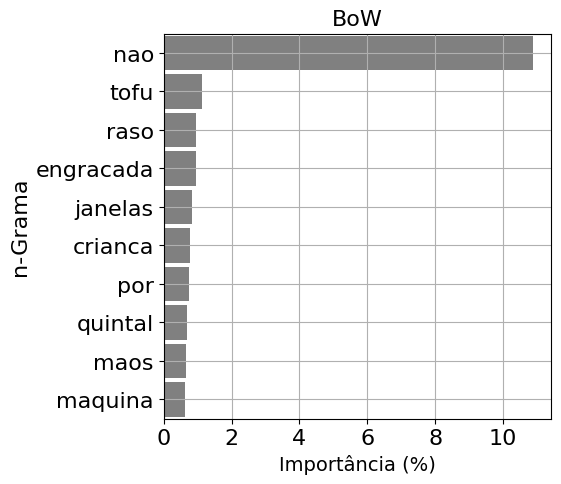

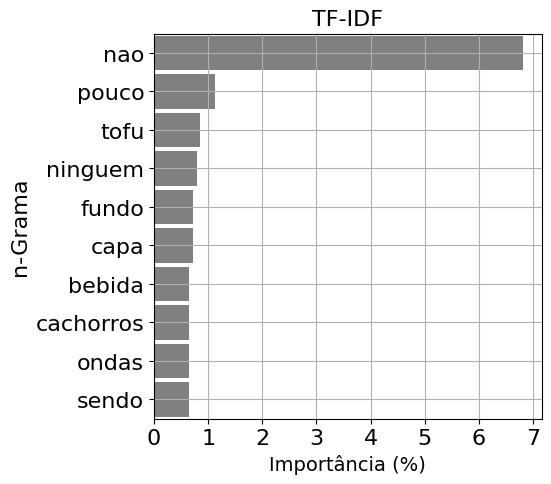

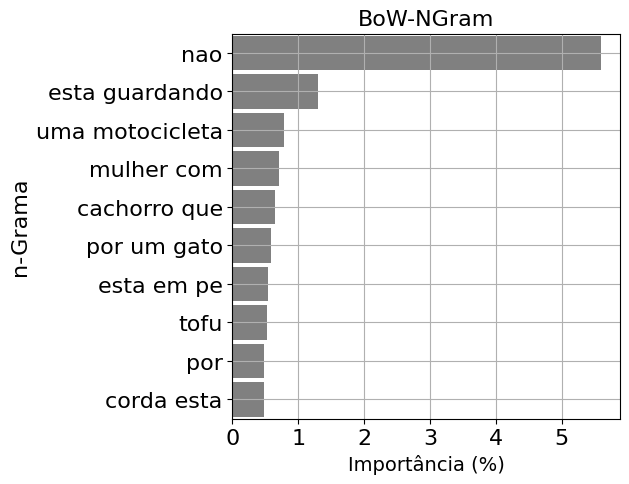

In [ ]:
def plot_importance_graph(df_importances, title):
    df_importances['importance_perc'] = df_importances['importance'] * 100
    plt.figure(figsize=(5, 5))
    sns.barplot(df_importances, 
                x='importance_perc', 
                y='column', 
                saturation=0.5, 
                width=0.9, 
                orient='h',
                color='gray')
    plt.grid()
    plt.title(title, fontsize=16)
    plt.xlabel('Importância (%)', fontsize=14)
    plt.ylabel('n-Grama', fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.savefig(os.path.join('../data/output', title + '.png'), bbox_inches='tight', dpi=100)
    plt.show()
    
plot_importance_graph(df_first_approach_importances, title='BoW')
plot_importance_graph(df_third_approach_importances, title='TF-IDF')
plot_importance_graph(df_fourth_approach_importances, title='BoW-NGram')